In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Conv2DTranspose, Flatten, Reshape, Input, BatchNormalization, Activation
from tensorflow.keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
import keras.backend as K

import pickle
import joblib

In [2]:
subsets = ['CelebA', 'Gopro', 'HIDE', 'Helen', 'RealBlur_J', 'RealBlur_R', 'TextOCR', 'Wider-Face']
print(subsets)

['CelebA', 'Gopro', 'HIDE', 'Helen', 'RealBlur_J', 'RealBlur_R', 'TextOCR', 'Wider-Face']


In [3]:
train_frames_path = 'DBlur/' + subsets[0] + '/train/'
val_frames_path = 'DBlur/' + subsets[0] + '/validation/'
test_frames_path = 'DBlur/' + subsets[0] + '/test/'

print(train_frames_path)
print(val_frames_path)
print(test_frames_path)

DBlur/CelebA/train/
DBlur/CelebA/validation/
DBlur/CelebA/test/


In [4]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.0
    img = np.reshape(img, (64, 64, 3))
    return img

In [5]:
# Training set
train_blurred_frames = os.listdir(train_frames_path + 'blur/')[:5000]
train_sharp_frames = os.listdir(train_frames_path + 'sharp/')[:5000]

# validation set
val_blurred_frames = os.listdir(val_frames_path + 'blur/')[:1000]
val_sharp_frames = os.listdir(val_frames_path + 'sharp/')[:1000]

# Testing set
test_blurred_frames = os.listdir(test_frames_path + 'blur/')[:1000]
test_sharp_frames = os.listdir(test_frames_path + 'sharp/')[:1000]

In [6]:
# Training set
train_blurred_frames = [process_image(train_frames_path + 'blur/' + file) for file in train_blurred_frames]
train_sharp_frames = [process_image(train_frames_path + 'sharp/' + file) for file in train_sharp_frames]

# validation set
val_blurred_frames = [process_image(val_frames_path + 'blur/' + file) for file in val_blurred_frames]
val_sharp_frames = [process_image(val_frames_path + 'sharp/' + file) for file in val_sharp_frames]

# Testing set
test_blurred_frames = [process_image(test_frames_path + 'blur/' + file) for file in test_blurred_frames]
test_sharp_frames = [process_image(test_frames_path + 'sharp/' + file) for file in test_sharp_frames]

In [7]:
# Training set
print(len(train_blurred_frames))
print(len(train_sharp_frames))

# validation set
print(len(val_blurred_frames))
print(len(val_sharp_frames))

# Testing set
print(len(test_blurred_frames))
print(len(test_sharp_frames))

5000
5000
1000
1000
1000
1000


In [8]:
# Training set
train_blurred_frames = np.asarray(train_blurred_frames)
train_sharp_frames = np.asarray(train_sharp_frames)

# validation set
val_blurred_frames = np.asarray(val_blurred_frames)
val_sharp_frames = np.asarray(val_sharp_frames)

# Testing set
test_blurred_frames = np.asarray(test_blurred_frames)
test_sharp_frames = np.asarray(test_sharp_frames)

In [9]:
print('Training set:', train_blurred_frames.shape, train_sharp_frames.shape)
print('Validation set:', val_blurred_frames.shape, val_sharp_frames.shape)
print('Testing set:', test_blurred_frames.shape, test_sharp_frames.shape)

Training set: (5000, 64, 64, 3) (5000, 64, 64, 3)
Validation set: (1000, 64, 64, 3) (1000, 64, 64, 3)
Testing set: (1000, 64, 64, 3) (1000, 64, 64, 3)


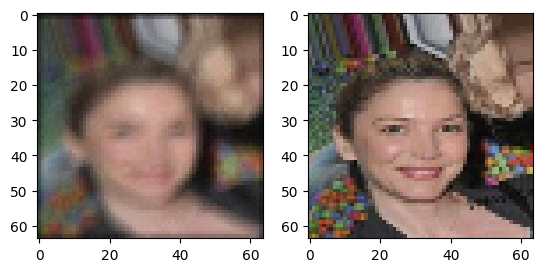

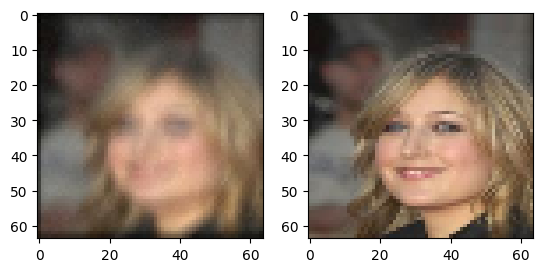

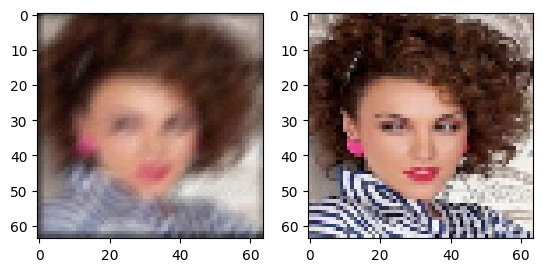

In [10]:
for cnt in range(3):   
    index = random.randint(0, len(train_blurred_frames)-1)

    image_blur = train_blurred_frames[index]
    image_sharp = train_sharp_frames[index]

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(image_blur)

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(image_sharp)

In [11]:
deblur_CNN_input = Input(shape=(64,64,3))

# HIDDEN LAYERS
deblur_CNN_layer1 = Conv2D(filters=128, kernel_size=10, strides=1, padding='same')(deblur_CNN_input)
deblur_CNN_layer1 = BatchNormalization()(deblur_CNN_layer1)
deblur_CNN_layer1 = Activation('relu')(deblur_CNN_layer1)

deblur_CNN_layer2 = Conv2D(filters=320, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer1)
deblur_CNN_layer2 = BatchNormalization()(deblur_CNN_layer2)
deblur_CNN_layer2 = Activation('relu')(deblur_CNN_layer2)

deblur_CNN_layer3 = Conv2D(filters=320, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer2)
deblur_CNN_layer1 = BatchNormalization()(deblur_CNN_layer3)
deblur_CNN_layer1 = Activation('relu')(deblur_CNN_layer3)

deblur_CNN_layer4 = Conv2D(filters=320, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer3)
deblur_CNN_layer4 = BatchNormalization()(deblur_CNN_layer4)
deblur_CNN_layer4 = Activation('relu')(deblur_CNN_layer4)

deblur_CNN_layer5 = Conv2D(filters=128, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer4)
deblur_CNN_layer5 = BatchNormalization()(deblur_CNN_layer5)
deblur_CNN_layer5 = Activation('relu')(deblur_CNN_layer5)

deblur_CNN_layer6 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(deblur_CNN_layer5)
deblur_CNN_layer6 = BatchNormalization()(deblur_CNN_layer6)
deblur_CNN_layer6 = Activation('relu')(deblur_CNN_layer6)

deblur_CNN_layer7 = Conv2D(filters=512, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer6)
deblur_CNN_layer7 = BatchNormalization()(deblur_CNN_layer7)
deblur_CNN_layer7 = Activation('relu')(deblur_CNN_layer7)

deblur_CNN_layer8 = Conv2D(filters=128, kernel_size=5, strides=1, padding='same')(deblur_CNN_layer7)
deblur_CNN_layer8 = BatchNormalization()(deblur_CNN_layer8)
deblur_CNN_layer8 = Activation('relu')(deblur_CNN_layer8)

deblur_CNN_layer9 = Conv2D(filters=128, kernel_size=5, strides=1, padding='same')(deblur_CNN_layer8)
deblur_CNN_layer9 = BatchNormalization()(deblur_CNN_layer9)
deblur_CNN_layer9 = Activation('relu')(deblur_CNN_layer9)

deblur_CNN_layer10 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(deblur_CNN_layer9)
deblur_CNN_layer10 = BatchNormalization()(deblur_CNN_layer10)
deblur_CNN_layer10 = Activation('relu')(deblur_CNN_layer10)

deblur_CNN_layer11 = Conv2D(filters=128, kernel_size=5, strides=1, padding='same')(deblur_CNN_layer10)
deblur_CNN_layer11 = BatchNormalization()(deblur_CNN_layer11)
deblur_CNN_layer11 = Activation('relu')(deblur_CNN_layer11)

deblur_CNN_layer12 = Conv2D(filters=128, kernel_size=5, strides=1, padding='same')(deblur_CNN_layer11)
deblur_CNN_layer12 = BatchNormalization()(deblur_CNN_layer12)
deblur_CNN_layer12 = Activation('relu')(deblur_CNN_layer12)

deblur_CNN_layer13 = Conv2D(filters=256, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer12)
deblur_CNN_layer13 = BatchNormalization()(deblur_CNN_layer13)
deblur_CNN_layer13 = Activation('relu')(deblur_CNN_layer13)

deblur_CNN_layer14 = Conv2D(filters=64, kernel_size=7, strides=1, padding='same')(deblur_CNN_layer13)
deblur_CNN_layer14 = BatchNormalization()(deblur_CNN_layer14)
deblur_CNN_layer14 = Activation('relu')(deblur_CNN_layer14)

deblur_CNN_output = Conv2D(filters=3, kernel_size=7, strides=1, padding='same', activation='relu')(deblur_CNN_layer14)

deblur_CNN = Model(inputs=deblur_CNN_input, outputs=deblur_CNN_output)

In [12]:
deblur_CNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [13]:
deblur_CNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 320)    │        41,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 320)    │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 320)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 320)    │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 320)    │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 320)    │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 320)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 512)    │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           51

 Total params: 4,410,563 (16.82 MB)

 Trainable params: 4,405,571 (16.81 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [1]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), 
                               cooldown=0, 
                               patience=5, 
                               verbose=1, 
                               min_lr=0.5e-6)

ES = EarlyStopping(patience=5, 
                   mode='min', 
                   monitor='val_loss', 
                   restore_best_weights=True)
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs detected:", gpus)
else:
    print("No GPU detected.")

NameError: name 'ReduceLROnPlateau' is not defined

In [15]:

# Enable TensorFlow logging to see device placement
tf.debugging.set_log_device_placement(True)
history = deblur_CNN.fit(train_blurred_frames, 
                         train_sharp_frames, 
                         epochs=20, 
                         batch_size=32, 
                         validation_data=(val_blurred_frames, val_sharp_frames), 
                         callbacks=[lr_reducer, ES])

Epoch 1/20
  6/157 ━━━━━━━━━━━━━━━━━━━━ 28:57 12s/step - accuracy: 0.3739 - loss: 0.5270

KeyboardInterrupt: 

In [2]:
import tensorflow as tf
print(tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())
import torch
print("torch.cuda.is_available() : ",torch.cuda.is_available())
print("torch.cuda.device_count() : ",torch.cuda.device_count())

2.17.0
Built with CUDA: False
Built with GPU support: False
torch.cuda.is_available() :  True
torch.cuda.device_count() :  1


In [ ]:
loss, accuracy = deblur_CNN.evaluate(test_blurred_frames, test_sharp_frames)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [20]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('De-Blur Model Loss')
plt.savefig('De-Blur-Model-Loss.png')
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x800 with 0 Axes>

In [21]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.savefig('De-Blur-Model-Accuracy.png')
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x800 with 0 Axes>


			Input						Ground Truth						Predicted Value


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0..19.3347].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0..8.835131].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0..10.774345].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0..26.948606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0..6.581704].


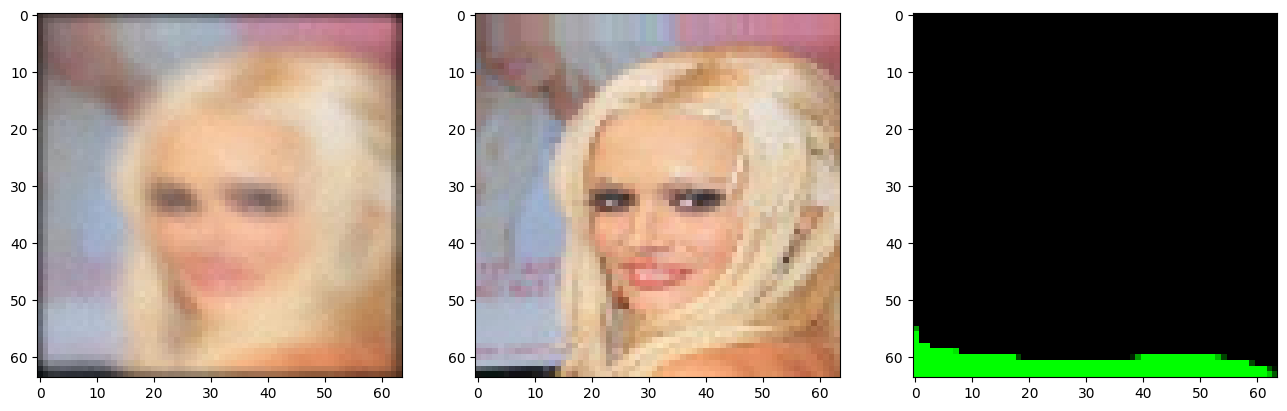

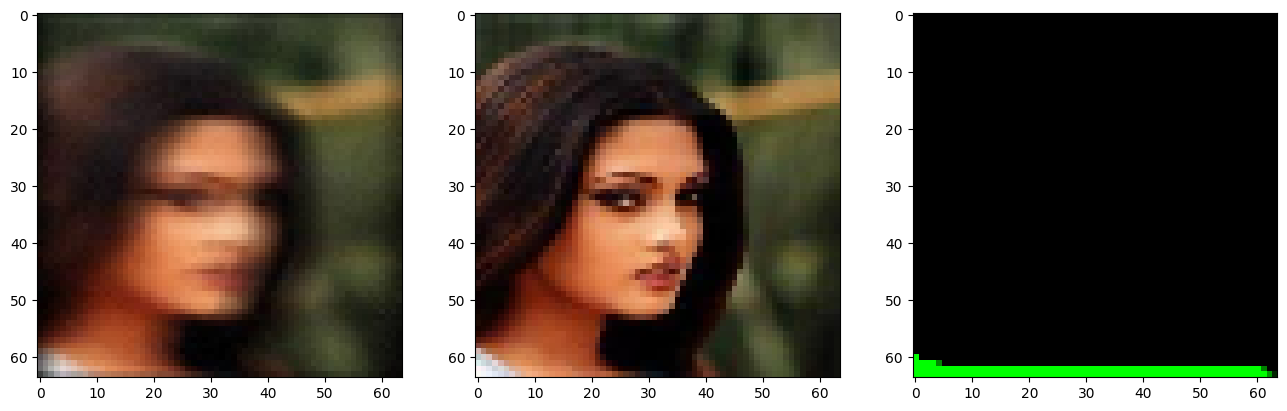

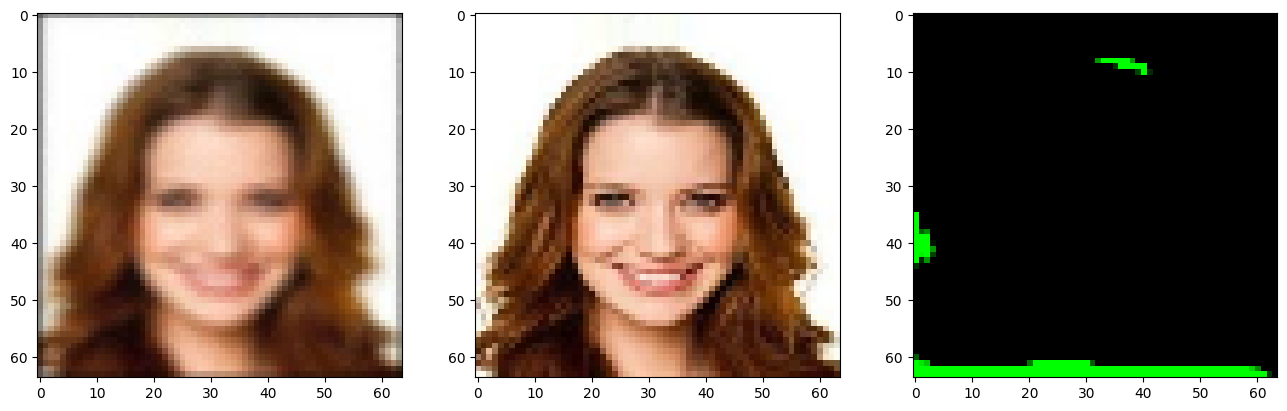

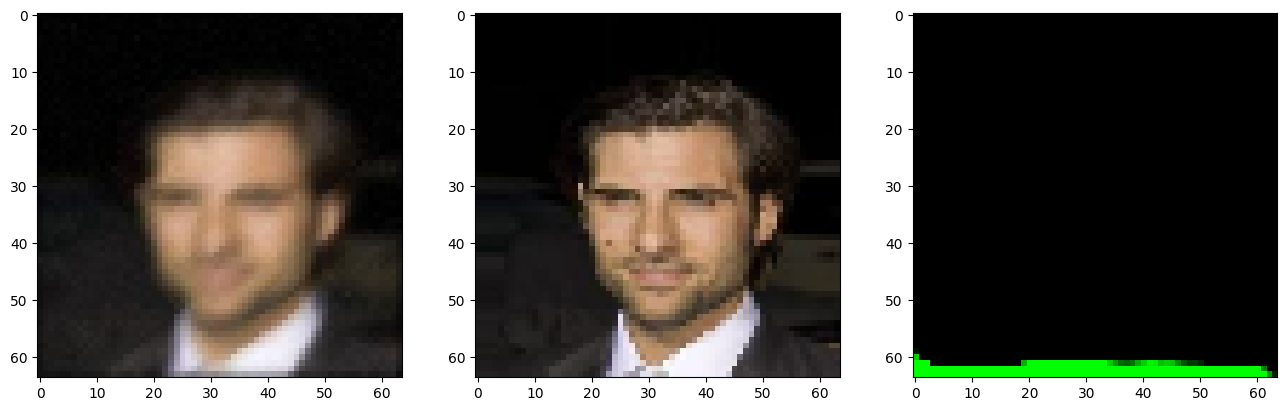

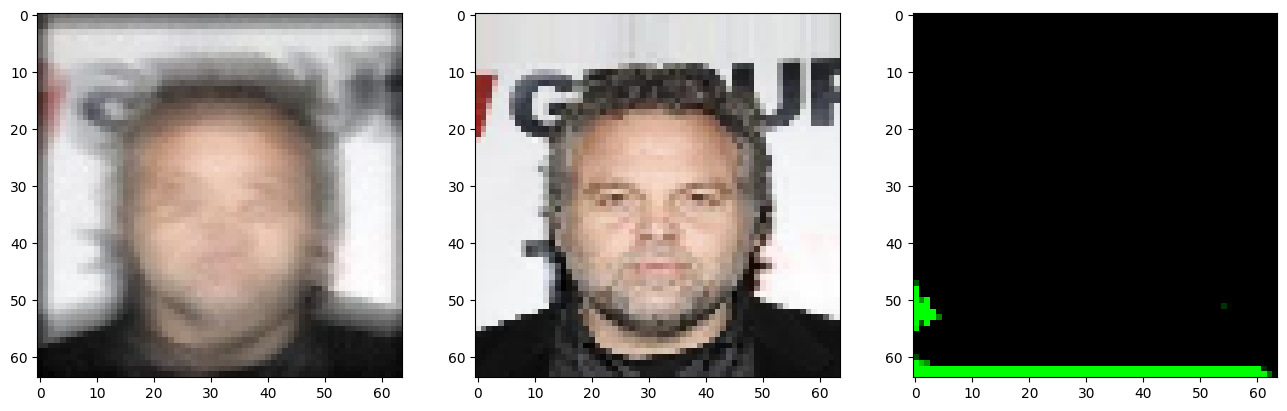

In [22]:
print("\n\t\t\tInput\t\t\t\t\t\tGround Truth\t\t\t\t\t\tPredicted Value")

for i in range(5):
    index = random.randint(0, len(test_blurred_frames)-1)

    x = test_blurred_frames[index]
    y = test_sharp_frames[index]

    x_inp = x.reshape(1,64,64,3)
    result = deblur_CNN.predict(x_inp, verbose = 0)
    result = result.reshape(64,64,3)

    fig = plt.figure(figsize=(16,13))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    
    fig.savefig('deblur_result.png')
    plt.imshow(result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0..14.10627].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0..4.9739246].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0..18.722277].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0..5.56227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0..18.175526].


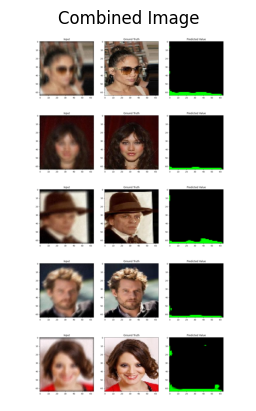

Combined image saved successfully: deblur_result.png


In [23]:
subplot_paths = []

for i in range(5):
    index = random.randint(0, len(test_blurred_frames) - 1)

    x = test_blurred_frames[index]
    y = test_sharp_frames[index]

    x_inp = x.reshape(1, 64, 64, 3)
    result = deblur_CNN.predict(x_inp, verbose=0)
    result = result.reshape(64, 64, 3)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    axes[0].imshow(x)
    axes[0].set_title("Input")

    axes[1].imshow(y)
    axes[1].set_title("Ground Truth")

    axes[2].imshow(result)
    axes[2].set_title("Predicted Value")

    subplot_path = f"subplot_{i + 1}.png"
    plt.savefig(subplot_path)
    plt.close(fig)

    subplot_paths.append(subplot_path)

combined_image = np.concatenate([plt.imread(path) for path in subplot_paths], axis=0)

output_image_path = "deblur_result.png"
plt.imsave(output_image_path, combined_image)

plt.imshow(combined_image)
plt.axis('off')
plt.title("Combined Image")
plt.show()

print("Combined image saved successfully:", output_image_path)

In [ ]:
model_json = deblur_CNN.to_json()
with open("deblur_CNN_architecture.json", "w") as json_file:
    json_file.write(model_json)

deblur_CNN.save_weights("deblur_CNN.weights.h5")